<a href="https://colab.research.google.com/github/sweetyjunnarkar/Kernel_performance_prediction/blob/main/SGEMM_GPU_Kernel_Performance_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Predicting the running times for multiplying two 2048 x 2048 matrices using a GPU OpenCL SGEMM kernel with varying parameters (using the library 'CLTune'). </u></b>

## <b> Problem Description </b>

### This data set measures the running time of a matrix-matrix product $A*B = C$, where all matrices have size 2048 x 2048, using a parameterizable SGEMM GPU kernel with 241600 possible parameter combinations. For each tested combination, 4 runs were performed and their results are reported as the 4 last columns. All times are measured in milliseconds*.

### There are 14 parameter, the first 10 are ordinal and can only take up to 4 different powers of two values, and the 4 last variables are binary. Out of 1327104 total parameter combinations, only 241600 are feasible (due to various kernel constraints). This data set contains the results for all these feasible combinations.

### The experiment was run on a desktop workstation running Ubuntu 16.04 Linux with an Intel Core i5 (3.5GHz), 16GB RAM, and a NVidia Geforce GTX 680 4GB GF580 GTX-1.5GB GPU. We use the 'gemm_fast' kernel from the automatic OpenCL kernel tuning library 'CLTune' ([Web Link]).

#### * Note: for this kind of data sets it is usually better to work with the logarithm of the running times 


## <b> Data Description </b>

### <b>Attribute Information: </b>

### Independent variables:
* ### MWG, NWG: per-matrix 2D tiling at workgroup level: {16, 32, 64, 128} (integer)
* ### KWG: inner dimension of 2D tiling at workgroup level: {16, 32} (integer)
* ### MDIMC, NDIMC: local workgroup size: {8, 16, 32} (integer)
* ### MDIMA, NDIMB: local memory shape: {8, 16, 32} (integer)
* ### KWI: kernel loop unrolling factor: {2, 8} (integer)
* ### VWM, VWN: per-matrix vector widths for loading and storing: {1, 2, 4, 8} (integer)
* ### STRM, STRN: enable stride for accessing off-chip memory within a single thread: {0, 1} (categorical)
* ### SA, SB: per-matrix manual caching of the 2D workgroup tile: {0, 1} (categorical)

### Output:
* ### Run1, Run2, Run3, Run4: performance times in milliseconds for 4 independent runs using the same parameters. They range between 13.25 and 3397.08.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
df=pd.read_csv("/content/drive/MyDrive/AlmaBetter/Cohort Aravali/Module 4/Week 2/sgemm_product.csv")

In [4]:
df

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241595,128,128,32,32,32,32,32,8,4,4,1,0,1,1,17.96,17.77,17.77,17.77
241596,128,128,32,32,32,32,32,8,4,4,1,1,0,0,36.04,36.03,36.04,36.03
241597,128,128,32,32,32,32,32,8,4,4,1,1,0,1,35.28,34.82,35.27,35.27
241598,128,128,32,32,32,32,32,8,4,4,1,1,1,0,28.43,28.49,28.44,28.45


In [5]:
df.isnull().sum()

MWG          0
NWG          0
KWG          0
MDIMC        0
NDIMC        0
MDIMA        0
NDIMB        0
KWI          0
VWM          0
VWN          0
STRM         0
STRN         0
SA           0
SB           0
Run1 (ms)    0
Run2 (ms)    0
Run3 (ms)    0
Run4 (ms)    0
dtype: int64

In [6]:

df.describe().T

,count,mean,std,min,25%,50%,75%,max
MWG,241600.0,80.415364,42.469220,16.00,32.00,64.000,128.00,128.00
NWG,241600.0,80.415364,42.469220,16.00,32.00,64.000,128.00,128.00
KWG,241600.0,25.513113,7.855619,16.00,16.00,32.000,32.00,32.00
MDIMC,241600.0,13.935894,7.873662,8.00,8.00,8.000,16.00,32.00
NDIMC,241600.0,13.935894,7.873662,8.00,8.00,8.000,16.00,32.00
MDIMA,241600.0,17.371126,9.389418,8.00,8.00,16.000,32.00,32.00
NDIMB,241600.0,17.371126,9.389418,8.00,8.00,16.000,32.00,32.00
KWI,241600.0,5.000000,3.000006,2.00,2.00,5.000,8.00,8.00
VWM,241600.0,2.448609,1.953759,1.00,1.00,2.000,4.00,8.00
VWN,241600.0,2.448609,1.953759,1.00,1.00,2.000,4.00,8.00


In [7]:
df["Run_avg"]=df[["Run1 (ms)","Run2 (ms)","Run3 (ms)","Run4 (ms)"]].mean(axis=1)

In [8]:
df

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms),Run_avg
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80,116.3700
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19,78.7050
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97,80.5650
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58,86.6375
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81,118.6625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241595,128,128,32,32,32,32,32,8,4,4,1,0,1,1,17.96,17.77,17.77,17.77,17.8175
241596,128,128,32,32,32,32,32,8,4,4,1,1,0,0,36.04,36.03,36.04,36.03,36.0350
241597,128,128,32,32,32,32,32,8,4,4,1,1,0,1,35.28,34.82,35.27,35.27,35.1600
241598,128,128,32,32,32,32,32,8,4,4,1,1,1,0,28.43,28.49,28.44,28.45,28.4525


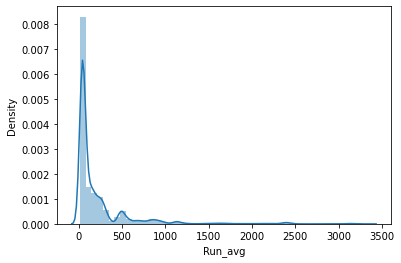

In [9]:
sns.distplot(df["Run_avg"])

In [15]:
cols_to_transform = ['MWG', 'NWG', 'KWG','MDIMC','NDIMC','MDIMA','NDIMB','KWI','VWM','VWN','STRM','STRN','SA','SB']
df_with_dummies = pd.get_dummies(df,columns = cols_to_transform )

In [16]:
df_with_dummies

,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms),Run_avg,MWG_16,MWG_32,MWG_64,MWG_128,NWG_16,NWG_32,NWG_64,NWG_128,KWG_16,KWG_32,MDIMC_8,MDIMC_16,MDIMC_32,NDIMC_8,NDIMC_16,NDIMC_32,MDIMA_8,MDIMA_16,MDIMA_32,NDIMB_8,NDIMB_16,NDIMB_32,KWI_2,KWI_8,VWM_1,VWM_2,VWM_4,VWM_8,VWN_1,VWN_2,VWN_4,VWN_8,STRM_0,STRM_1,STRN_0,STRN_1,SA_0,SA_1,SB_0,SB_1
0,115.26,115.87,118.55,115.80,116.3700,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0
1,78.13,78.25,79.25,79.19,78.7050,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1
2,79.84,80.69,80.76,80.97,80.5650,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0
3,84.32,89.90,86.75,85.58,86.6375,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1
4,115.13,121.98,122.73,114.81,118.6625,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241595,17.96,17.77,17.77,17.77,17.8175,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,1
241596,36.04,36.03,36.04,36.03,36.0350,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,0
241597,35.28,34.82,35.27,35.27,35.1600,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,0,1
241598,28.43,28.49,28.44,28.45,28.4525,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,1,0


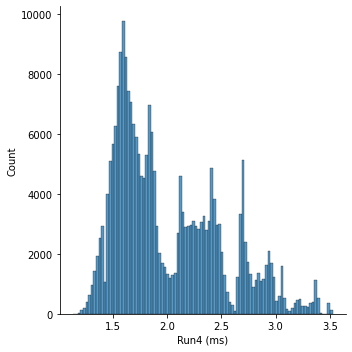

In [17]:
sns.displot(np.log10(df_with_dummies['Run4 (ms)']))

In [20]:
X=df_with_dummies.iloc[:,5:]
X

,MWG_16,MWG_32,MWG_64,MWG_128,NWG_16,NWG_32,NWG_64,NWG_128,KWG_16,KWG_32,MDIMC_8,MDIMC_16,MDIMC_32,NDIMC_8,NDIMC_16,NDIMC_32,MDIMA_8,MDIMA_16,MDIMA_32,NDIMB_8,NDIMB_16,NDIMB_32,KWI_2,KWI_8,VWM_1,VWM_2,VWM_4,VWM_8,VWN_1,VWN_2,VWN_4,VWN_8,STRM_0,STRM_1,STRN_0,STRN_1,SA_0,SA_1,SB_0,SB_1
0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0
1,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1
2,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0
3,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1
4,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241595,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,1
241596,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,0
241597,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,0,1
241598,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,1,0


In [25]:
y=np.log(df_with_dummies['Run4 (ms)'])
y

0         4.751865
1         4.371850
2         4.394079
3         4.449452
4         4.743279
            ...   
241595    2.877512
241596    3.584352
241597    3.563033
241598    3.348148
241599    2.877512
Name: Run4 (ms), Length: 241600, dtype: float64

In [26]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [28]:
regr = LinearRegression() 
  
regr.fit(X_train, y_train) 
print(regr.score(X_test, y_test))

0.6020838649240201
